In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from routines.models import get_pipe_base
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.kernel_approximation import RBFSampler, Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from routines.models import get_balanced_sample_weights, ks_test_d, ks_test_p
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report, roc_auc_score, f1_score, log_loss
from time import time
from time import localtime
from routines.transformers import SparseTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm as sp_norm
from routines.evals_n_plots import get_cv_res_df, plot_cv_res_df, plot_permut_hist, plot_learning_curve, \
    plot_multi_metric_cv, plot_confusion_matrix, plot_roc_curve, plot_prc_curve
from sklearn.model_selection import permutation_test_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from scipy.stats import ks_2samp
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

### Set params

In [2]:
random_state: int = 42
sample_test_size: float = 0.20
max_jobs: int = 3
pre_dispatch = 3
outer_cv: int = 5
inner_cv: int = 3

### Load training set

In [3]:
df = pd.read_csv('src/Train_Sample.csv', sep=';', index_col=0)
y = df['Status']
X = df.drop(labels='Status', axis=1, inplace=False)
del df
print('X.shape: {0}\ty.shape: {1}'.format(X.shape, y.shape))

X.shape: (65974, 221)	y.shape: (65974,)


### Split training set into train-test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_test_size,
                                                    random_state=random_state,
                                                    stratify=y)
print('X_train.shape: {0}\ty_train.shape: {1}\n'
      'X_test.shape: {2}\ty_test.shape: {3}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (52779, 221)	y_train.shape: (52779,)
X_test.shape: (13195, 221)	y_test.shape: (13195,)



### Load base pipe (extract base features)

In [5]:
corr_threshold = 0.90
var_threshold = (0.98 * (1.00 - 0.98))

pipe_base = get_pipe_base(random_state=random_state, corr_threshold=corr_threshold, var_threshold=var_threshold)
# pipe_base

### Fit Voting Classifier

In [8]:
pipe_vc = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),

                          ('VC', VotingClassifier(estimators=[('LR',
                                                               Pipeline(steps=[('pca',
                                                                                PCA(n_components='mle',
                                                                                    # n_components=212,
                                                                                    svd_solver='full',
                                                                                    random_state=random_state)),
                                                                               ('logistic',
                                                                                LogisticRegression(
                                                                                    random_state=random_state,
                                                                                    n_jobs=max_jobs,
                                                                                    class_weight='balanced',
                                                                                    penalty='l2',
                                                                                    solver='lbfgs',
                                                                                    # solver='sag',  #'saga'
                                                                                    max_iter=1000,
                                                                                    C=27.0, )),
                                                                               ])
                                                               ),
                                                              ('RF_calibrated', CalibratedClassifierCV(
                                                                  base_estimator=RandomForestClassifier(
                                                                      random_state=random_state,
                                                                      n_jobs=max_jobs,
                                                                      criterion='entropy',
                                                                      class_weight='balanced_subsample',
                                                                      bootstrap=True,
                                                                      oob_score=False,
                                                                      n_estimators=300,
                                                                      max_features='sqrt',
                                                                      max_depth=None,
                                                                      min_samples_leaf=1,
                                                                      min_impurity_decrease=0.0095, ),
                                                                  cv=5, method='isotonic')),
                                                              ('GB_calibrated', CalibratedClassifierCV(
                                                                  base_estimator=GradientBoostingClassifier(
                                                                      random_state=random_state,
                                                                      loss='deviance',
                                                                      criterion='friedman_mse',
                                                                      subsample=0.50,
                                                                      presort=True,
                                                                      n_estimators=300,
                                                                      learning_rate=0.1,
                                                                      max_features='sqrt',
                                                                      max_depth=4,
                                                                      min_samples_leaf=0.155,
                                                                      min_impurity_decrease=0.00, ),
                                                                  cv=8, method='isotonic')),
                                                              ],
                                                  voting='soft',
                                                  weights=None,
                                                  n_jobs=max_jobs,
                                                  flatten_transform=None, )),
                          ],
                   # memory='pipe_cache/'
                   )


In [9]:
t0 = time()
pipe_vc.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  197.16272377967834


In [10]:
t0 = time()
pipe_vc_pred_train = pipe_vc.predict(X_train)
pipe_vc_pred_test = pipe_vc.predict(X_test)
pipe_vc_proba_train = pipe_vc.predict_proba(X_train)
pipe_vc_proba_test = pipe_vc.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  25.685248374938965


In [33]:
print('#TRAIN VC#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, pipe_vc_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=pipe_vc_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, pipe_vc_pred_train),
                ks_2samp(y_train, pipe_vc_pred_train)[0],
                ks_2samp(y_train, pipe_vc_pred_train)[1],
                log_loss(y_train, pipe_vc_proba_train[:, 1]), ))

print('\n#TEST VC#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, pipe_vc_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=pipe_vc_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, pipe_vc_pred_test),
                ks_2samp(y_test, pipe_vc_pred_test)[0],
                ks_2samp(y_test, pipe_vc_pred_test)[1],
                log_loss(y_test, pipe_vc_proba_test[:, 1]), ))

#TRAIN VC#
AUC: 0.8525058080837687
F1: 0.36579831170009985
MCC: 0.32072848774487434
KS: D=0.06659845771992645, p-value=3.0505415287114118e-102
Log Loss: 0.3095794370492794

#TEST VC#
AUC: 0.8459309531666601
F1: 0.3608065086664308
MCC: 0.3163768503080902
KS: D=0.07207275483137554, p-value=2.78583904998641e-30
Log Loss: 0.31921899992189595


In [13]:
print(classification_report(y_test, pipe_vc_pred_test))

             precision    recall  f1-score   support

          0       0.96      0.89      0.92     12257
          1       0.27      0.54      0.36       938

avg / total       0.91      0.86      0.88     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

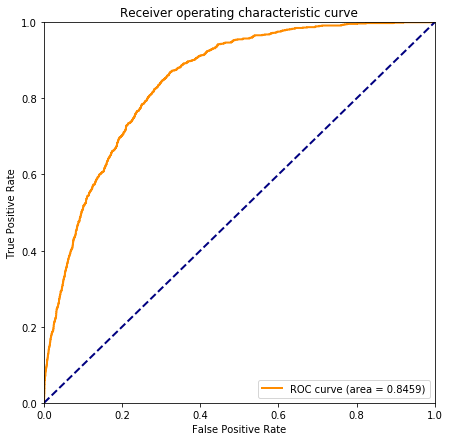

In [14]:
plot_roc_curve(target=y_test, proba=pipe_vc_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

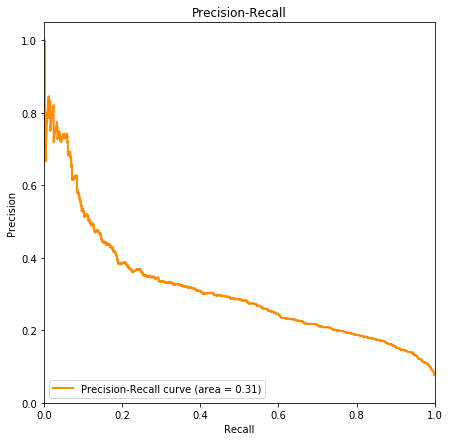

In [15]:
plot_prc_curve(target=y_test, proba=pipe_vc_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

### Plot calibration curves

In [16]:
cc_pipe_vc_true_pos, cc_pipe_vc_pred_pos = calibration_curve(y_test, pipe_vc_proba_test[:, 1], n_bins=10)

Text(0.5,1,'Calibration curves')

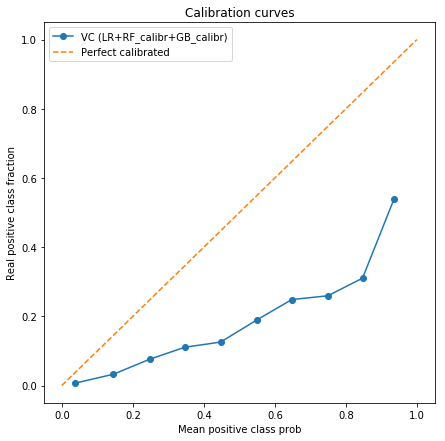

In [19]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
# plt.plot(cc_calib_rf_pred_pos, cc_calib_rf_true_pos, '-o', label='RF_calibrated (cv=5)', axes=ax)
# plt.plot(cc_pipe_rf_pred_pos, cc_pipe_rf_true_pos, '--o', label='RF (no calibration)', axes=ax)
# plt.plot(cc_calib_lr_pred_pos, cc_calib_lr_true_pos, '-o', label='LR_calibrated (cv=5)', axes=ax)
# plt.plot(cc_pipe_lr_pred_pos, cc_pipe_lr_true_pos, '--o', label='LR (no calibration)', axes=ax)
plt.plot(cc_pipe_vc_pred_pos, cc_pipe_vc_true_pos, '-o', label='VC (LR+RF_calibr+GB_calibr)', axes=ax)
plt.plot([0, 1], [0, 1], '--', label='Perfect calibrated')
ax.set_xlabel('Mean positive class prob')
ax.set_ylabel('Real positive class fraction')
ax.legend(loc='best')
ax.set_title('Calibration curves')

### Learning curve

In [17]:
t0 = time()
lc_vc_train_sizes, lc_vc_train_scores, lc_vc_test_scores = learning_curve(estimator=pipe_vc, X=X_test, y=y_test,
                                                                          cv=inner_cv, n_jobs=max_jobs,
                                                                          scoring='roc_auc',
                                                                          train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  237.0113217830658


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

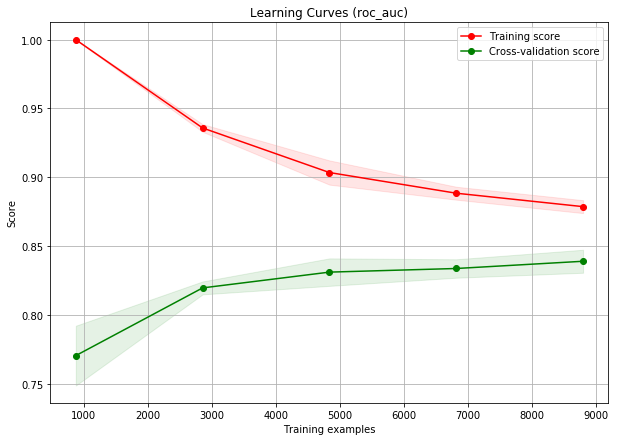

In [20]:
plot_learning_curve(train_sizes=lc_vc_train_sizes, train_scores=lc_vc_train_scores, test_scores=lc_vc_test_scores,
                    title='Learning Curves (roc_auc)', ylim=None, figsize=(10, 7))

## FIT TOTAL

In [27]:
t0 = time()
pipe_vc.fit(X, y)
print('Fit Time: ', (time() - t0))

Fit Time:  233.49204468727112


In [28]:
model_dump_fname = 'src/' + 'model_vc_lr_rf_gb_2017_12_15' + '.p'
pickle.dump(pipe_vc, open(model_dump_fname, 'wb'))
print('\npipeline dump file: ', model_dump_fname)


pipeline dump file:  src/model_vc_lr_rf_gb_2017_12_15.p


In [29]:
model_loaded = pickle.load(open('src/model_vc_lr_rf_gb_2017_12_15.p', 'rb'))
model_loaded

Pipeline(memory=None,
     steps=[('pipe_base', FeatureUnion(n_jobs=1,
       transformer_list=[('initial_selection', Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=Index(['par1', 'par10', 'par1...v=8, method='isotonic'))],
         flatten_transform=None, n_jobs=3, voting='soft', weights=None))])

##PREDICT TRAIN

In [31]:
t0 = time()
model_loaded_pred_train = model_loaded.predict(X)
model_loaded_proba_train = model_loaded.predict_proba(X)
print('Predict Time: ', (time() - t0))

Predict Time:  26.909921169281006


In [34]:
print('\n#TRAIN#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y, model_loaded_proba_train[:, 1]),
                f1_score(y_true=y, y_pred=model_loaded_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y, model_loaded_pred_train),
                ks_2samp(y, model_loaded_pred_train)[0],
                ks_2samp(y, model_loaded_pred_train)[1],
                log_loss(y, model_loaded_proba_train[:, 1]), ))


#TRAIN#
AUC: 0.8515570761285028
F1: 0.364350856380218
MCC: 0.31784111899962947
KS: D=0.0622821111346894, p-value=1.0231692618979243e-111
Log Loss: 0.3036357802243174


In [37]:
df_train = pd.DataFrame(model_loaded_proba_train[:, 1], columns=['proba_status_1'], index=X.index)
df_train.to_csv('src/Train_Sample_Res_vc_lrg_12_15.csv', sep=';', index=True, index_label='Id')
df_train.head(3)

,proba_status_1
Id,
1,0.006805
2,0.011993
3,0.019117


## PREDICT TEST

In [47]:
df_data = pd.read_csv('src/Test_Sample.csv', sep=';', index_col=0)
print('data.shape: {0}'.format(df_data.shape))

data.shape: (41907, 221)


In [48]:
t0 = time()
model_loaded_proba_test = model_loaded.predict_proba(df_data)
print('Predict Time: ', (time() - t0))

Predict Time:  8.300828218460083


In [49]:
df_test = pd.DataFrame(model_loaded_proba_test[:, 1], columns=['proba_status_1'], index=df_data.index)
df_test.to_csv('src/Test_Sample_Res_vc_lrg_12_15.csv', sep=';', index=True, index_label='Id')
df_test.head(3)

,proba_status_1
Id,
1,0.203708
2,0.050274
3,0.226294
